# From the Description can we predict the Flavors (Multi-Label prediction)

In [ ]:
#https://www.kaggle.com/roccoli/multi-label-classification-with-sklearn
#https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5
#https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/
#https://mlr.mlr-org.com/articles/tutorial/multilabel.html
#https://medium.com/coinmonks/multi-label-classification-blog-tags-prediction-using-nlp-b0b5ee6686fc

#https://github.com/nkartik94/Multi-Label-Text-Classification/blob/master/Mark_6.ipynb
#https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

In [38]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#printmd('**bold**')

In [2]:
df_review=pd.read_excel("../CannaConnect/Dataset/description_clean.xlsx")
df=df_review.Description.astype(str)
df.head()

0     og   hybrid strain pack strong punch name sup...
1     aloha white widow especially potent cut white...
2     sativa dominant hybrid bred spain medical see...
3     dawgs hybrid g chemdawg genetics bred canadia...
4    known kosher tangie k gold  indica dominant hy...
Name: Description, dtype: object

In [3]:
df.shape

(2349,)

In [4]:
EDA=pd.read_excel('../CannaConnect/Dataset/EDA.xlsx')
EDA.head()

,Unnamed: 0,Strain,Type,Rating,Effects,Flavor,Description,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Flavor_1,Flavor_2,Flavor_3,Flavor_4
0,0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,NaN
1,1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,NaN
2,2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,NaN
3,3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,NaN
4,4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,NaN


In [5]:
EDA=pd.DataFrame(EDA,columns=['Flavor_1','Flavor_2','Flavor_3','Flavor_4'])
EDA.head()

,Flavor_1,Flavor_2,Flavor_3,Flavor_4
0,Earthy,Sweet,Citrus,NaN
1,Flowery,Violet,Diesel,NaN
2,Spicy/Herbal,Sage,Woody,NaN
3,Apricot,Citrus,Grapefruit,NaN
4,Citrus,Earthy,Orange,NaN


In [6]:
EDA.fillna('None', inplace = True)

In [7]:
des_type=pd.concat([df,EDA],axis=1)
des_type.head()

,Description,Flavor_1,Flavor_2,Flavor_3,Flavor_4
0,og hybrid strain pack strong punch name sup...,Earthy,Sweet,Citrus,None
1,aloha white widow especially potent cut white...,Flowery,Violet,Diesel,None
2,sativa dominant hybrid bred spain medical see...,Spicy/Herbal,Sage,Woody,None
3,dawgs hybrid g chemdawg genetics bred canadia...,Apricot,Citrus,Grapefruit,None
4,known kosher tangie k gold indica dominant hy...,Citrus,Earthy,Orange,None


In [8]:
mlb=MultiLabelBinarizer()
Y=pd.DataFrame(mlb.fit_transform(des_type[['Flavor_1','Flavor_2','Flavor_3','Flavor_4']].values), columns=mlb.classes_, index=des_type.index)
print(Y.head())

   Ammonia  Apple  Apricot  Berry  Blue  Blueberry  Butter  Cheese  Chemical  \
0        0      0        0      0     0          0       0       0         0   
1        0      0        0      0     0          0       0       0         0   
2        0      0        0      0     0          0       0       0         0   
3        0      0        1      0     0          0       0       0         0   
4        0      0        0      0     0          0       0       0         0   

   Chestnut  ...  Strawberry  Sweet  Tar  Tea  Tobacco  Tree  Tropical  \
0         0  ...           0      1    0    0        0     0         0   
1         0  ...           0      0    0    0        0     0         0   
2         0  ...           0      0    0    0        0     0         0   
3         0  ...           0      0    0    0        0     0         0   
4         0  ...           0      0    0    0        0     0         0   

   Vanilla  Violet  Woody  
0        0       0      0  
1        0       1

In [9]:
des_type=pd.concat([df,Y],axis=1)
des_type.head()

,Description,Ammonia,Apple,Apricot,Berry,Blue,Blueberry,Butter,Cheese,Chemical,...,Strawberry,Sweet,Tar,Tea,Tobacco,Tree,Tropical,Vanilla,Violet,Woody
0,og hybrid strain pack strong punch name sup...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,aloha white widow especially potent cut white...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,sativa dominant hybrid bred spain medical see...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,dawgs hybrid g chemdawg genetics bred canadia...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,known kosher tangie k gold indica dominant hy...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
des_type.to_csv('../Cannjoin/Dataset/multiclass-flavor.csv')

In [11]:
categories = list(des_type.columns.values)
categories = categories[1:]
print(categories)

['Ammonia', 'Apple', 'Apricot', 'Berry', 'Blue', 'Blueberry', 'Butter', 'Cheese', 'Chemical', 'Chestnut', 'Citrus', 'Coffee', 'Diesel', 'Earthy', 'Flowery', 'Fruit', 'Grape', 'Grapefruit', 'Honey', 'Lavender', 'Lemon', 'Lime', 'Mango', 'Menthol', 'Mint', 'Minty', 'None', 'Nutty', 'Orange', 'Peach', 'Pear', 'Pepper', 'Pine', 'Pineapple', 'Plum', 'Pungent', 'Rose', 'Sage', 'Skunk', 'Spicy/Herbal', 'Strawberry', 'Sweet', 'Tar', 'Tea', 'Tobacco', 'Tree', 'Tropical', 'Vanilla', 'Violet', 'Woody']


In [12]:
counts = []
for category in categories:
    counts.append((category, des_type[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats.head()

,category,number of comments
0,Ammonia,28
1,Apple,16
2,Apricot,8
3,Berry,352
4,Blue,9


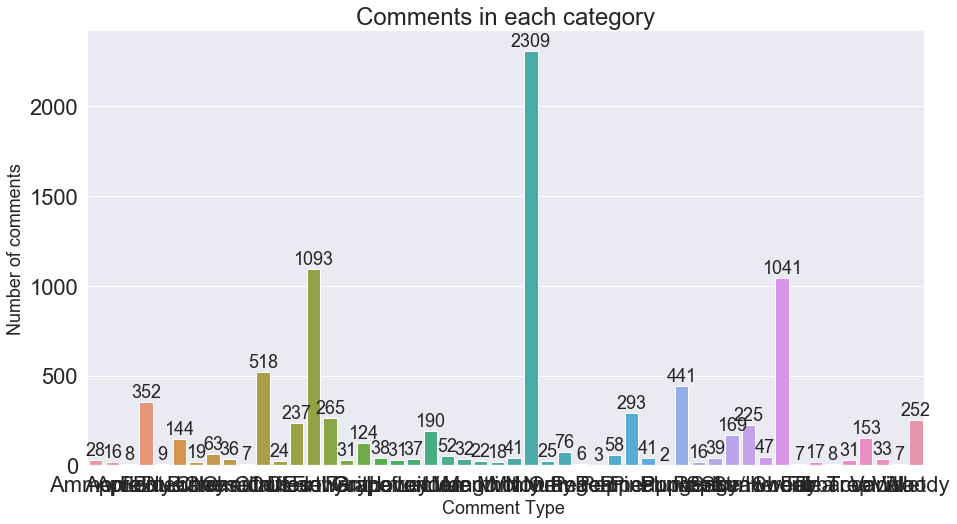

In [13]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, des_type.iloc[:,1:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = des_type.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

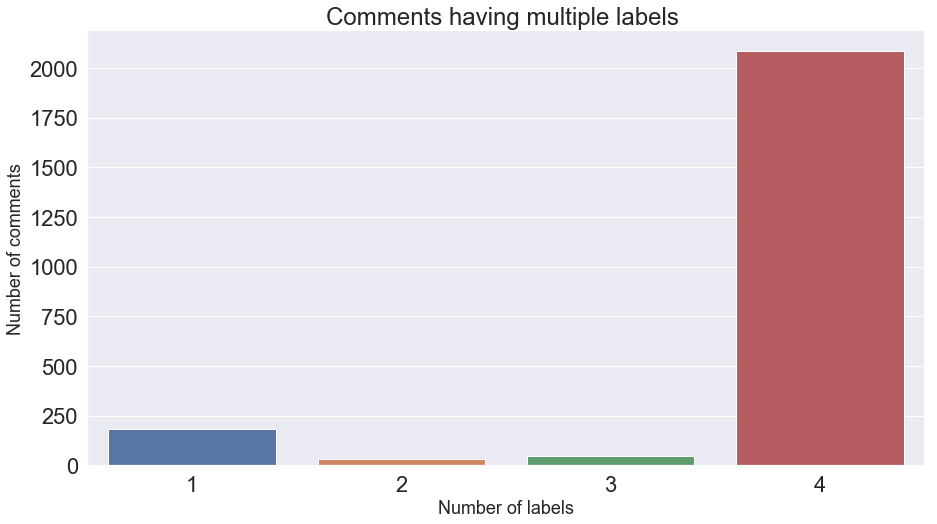

In [21]:
rowSums = des_type.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
#multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)


plt.show()

In [19]:
multiLabel_counts.head()

4    2085
1     182
3      48
2      34
dtype: int64

In [22]:
train, test = train_test_split(des_type, random_state=42, test_size=0.20, shuffle=True)
print(train.shape)
print(test.shape)

(1879, 51)
(470, 51)


In [23]:
train_text = train['Description']
test_text = test['Description']

In [24]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [25]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['Description'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['Description'], axis=1)

In [41]:
NB_pipeline = Pipeline([
                #('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(x_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Ammonia
Test accuracy is 0.9893617021276596
... Processing Apple
Test accuracy is 0.9957446808510638
... Processing Apricot
Test accuracy is 1.0
... Processing Berry
Test accuracy is 0.8531914893617021
... Processing Blue
Test accuracy is 0.9957446808510638
... Processing Blueberry
Test accuracy is 0.9234042553191489
... Processing Butter
Test accuracy is 0.9893617021276596
... Processing Cheese
Test accuracy is 0.9723404255319149
... Processing Chemical
Test accuracy is 0.9723404255319149
... Processing Chestnut
Test accuracy is 0.9914893617021276
... Processing Citrus
Test accuracy is 0.7851063829787234
... Processing Coffee
Test accuracy is 0.9936170212765958
... Processing Diesel
Test accuracy is 0.902127659574468
... Processing Earthy
Test accuracy is 0.5148936170212766
... Processing Flowery
Test accuracy is 0.8957446808510638
... Processing Fruit
Test accuracy is 0.9893617021276596
... Processing Grape
Test accuracy is 0.9553191489361702
... Processing Grapefruit


In [30]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    printmd('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing Ammonia comments...**

Test accuracy is 0.9893617021276596




**Processing Apple comments...**

Test accuracy is 0.9957446808510638




**Processing Apricot comments...**

Test accuracy is 1.0




**Processing Berry comments...**

Test accuracy is 0.8531914893617021




**Processing Blue comments...**

Test accuracy is 0.9957446808510638




**Processing Blueberry comments...**

Test accuracy is 0.9234042553191489




**Processing Butter comments...**

Test accuracy is 0.9893617021276596




**Processing Cheese comments...**

Test accuracy is 0.9723404255319149




**Processing Chemical comments...**

Test accuracy is 0.9723404255319149




**Processing Chestnut comments...**

Test accuracy is 0.9914893617021276




**Processing Citrus comments...**

Test accuracy is 0.7851063829787234




**Processing Coffee comments...**

Test accuracy is 0.9936170212765958




**Processing Diesel comments...**

Test accuracy is 0.902127659574468




**Processing Earthy comments...**

Test accuracy is 0.5574468085106383




**Processing Flowery comments...**

Test accuracy is 0.8957446808510638




**Processing Fruit comments...**

Test accuracy is 0.9893617021276596




**Processing Grape comments...**

Test accuracy is 0.9553191489361702




**Processing Grapefruit comments...**

Test accuracy is 0.9872340425531915




**Processing Honey comments...**

Test accuracy is 0.9829787234042553




**Processing Lavender comments...**

Test accuracy is 0.9893617021276596




**Processing Lemon comments...**

Test accuracy is 0.925531914893617




**Processing Lime comments...**

Test accuracy is 0.9765957446808511




**Processing Mango comments...**

Test accuracy is 0.9851063829787234




**Processing Menthol comments...**

Test accuracy is 0.9829787234042553




**Processing Mint comments...**

Test accuracy is 0.9957446808510638




**Processing Minty comments...**

Test accuracy is 0.9829787234042553




**Processing None comments...**

Test accuracy is 0.9851063829787234




**Processing Nutty comments...**

Test accuracy is 0.9893617021276596




**Processing Orange comments...**

Test accuracy is 0.9851063829787234




**Processing Peach comments...**

Test accuracy is 1.0




**Processing Pear comments...**

Test accuracy is 0.997872340425532




**Processing Pepper comments...**

Test accuracy is 0.9680851063829787




**Processing Pine comments...**

Test accuracy is 0.8978723404255319




**Processing Pineapple comments...**

Test accuracy is 0.9829787234042553




**Processing Plum comments...**

Test accuracy is 0.997872340425532




**Processing Pungent comments...**

Test accuracy is 0.7914893617021277




**Processing Rose comments...**

Test accuracy is 0.9872340425531915




**Processing Sage comments...**

Test accuracy is 0.9914893617021276




**Processing Skunk comments...**

Test accuracy is 0.925531914893617




**Processing Spicy/Herbal comments...**

Test accuracy is 0.8978723404255319




**Processing Strawberry comments...**

Test accuracy is 0.9872340425531915




**Processing Sweet comments...**

Test accuracy is 0.548936170212766




**Processing Tar comments...**

Test accuracy is 0.9914893617021276




**Processing Tea comments...**

Test accuracy is 0.9957446808510638




**Processing Tobacco comments...**

Test accuracy is 0.997872340425532




**Processing Tree comments...**

Test accuracy is 0.9893617021276596




**Processing Tropical comments...**

Test accuracy is 0.9170212765957447




**Processing Vanilla comments...**

Test accuracy is 0.9872340425531915




**Processing Violet comments...**

Test accuracy is 0.997872340425532




**Processing Woody comments...**

Test accuracy is 0.8914893617021277


Wall time: 8.71 s


In [31]:
%%time

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.031914893617021274


Wall time: 1min 46s


In [33]:
%%time

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

Accuracy =  0.00425531914893617


Wall time: 58 s


In [35]:
%%time

# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy =  0.07872340425531915


Wall time: 11 s


In [37]:
%%time

classifier_new = MLkNN(k=10)

# Note that this classifier can throw up errors when handling sparse matrices.

x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

Accuracy =  0.03404255319148936


Wall time: 3min 35s
